In [11]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
import glob
import matplotlib.pyplot as plt

from torch.utils.data import ConcatDataset, DataLoader
from catalyst import dl
from catalyst.utils import metrics
from torch.nn import functional as F

from vxs import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
torch.cuda.is_available()

False

In [13]:
vocal_sketch_dataset = SampleSet(glob.glob('../data/vocal_imitations_sketch_included/included/*.wav'), normalize=True)
drum_machines_dataset = SampleSet(glob.glob('../data/200DrumMachines/*/*.wav'), normalize=True)
common_set = ConcatDataset([vocal_sketch_dataset, drum_machines_dataset])

In [4]:
len(common_set)

11178

In [14]:
len(drum_machines_dataset)

6749

In [15]:
len(vocal_sketch_dataset)

4429

In [5]:
splitter = DataSplit(common_set, shuffle=True, test_train_split=1)
loaders = {
    'train': splitter.get_train_loader(),
    'valid': splitter.get_validation_loader()
}

model = ConvAE()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [6]:
class ConvAERunner(dl.Runner):
    def _handle_batch(self, batch):
        x, _ = batch          # ignore the raw waveform
        y, z = self.model(x)
        loss = F.mse_loss(y, x)
        self.batch_metrics = {
            'loss': loss
        }
        
        if self.is_train_loader:
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

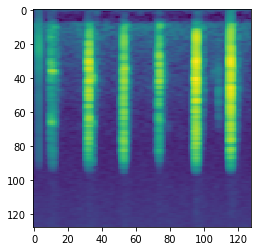

In [7]:
def sample_random(num, ln, seed):
    np.random.seed(seed)
    return np.random.randint(0, ln, size=num)

def imshow_random_samples(dataset, num, random_seed=42, cols=3):
    samples = sample_random(num, len(dataset), random_seed)
    rows = num // cols + (0 if num % cols == 0 else 1)
    fig, axes_t = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axes = [ax for tp in axes_t for ax in tp]
    
    for (sample_idx, ax) in zip(samples, axes):
        sample = dataset[sample_idx].squeeze(0).numpy()
        ax.imshow(sample)
        ax.set_title(sample_idx)
        
    plt.show()
    
def imshow_ae_output(model, dataset, num, random_seed=42):
    samples = sample_random(num, len(dataset), random_seed)
    fig, axes = plt.subplots(num, 3, figsize=(12, 4*num))
    
    for (sample_idx, (ax1, ax2, ax3)) in zip(samples, axes):
        sample = dataset[sample_idx]
        sample_out, z = model(sample.unsqueeze(0))
        ax1.imshow(sample.squeeze().numpy())
        ax2.imshow(sample_out.detach().squeeze().numpy())
        ax3.imshow(z.detach().squeeze().flatten(1).numpy())
        
    plt.show()
    
melgram = common_set[42]
plt.imshow(melgram.squeeze(0).numpy())

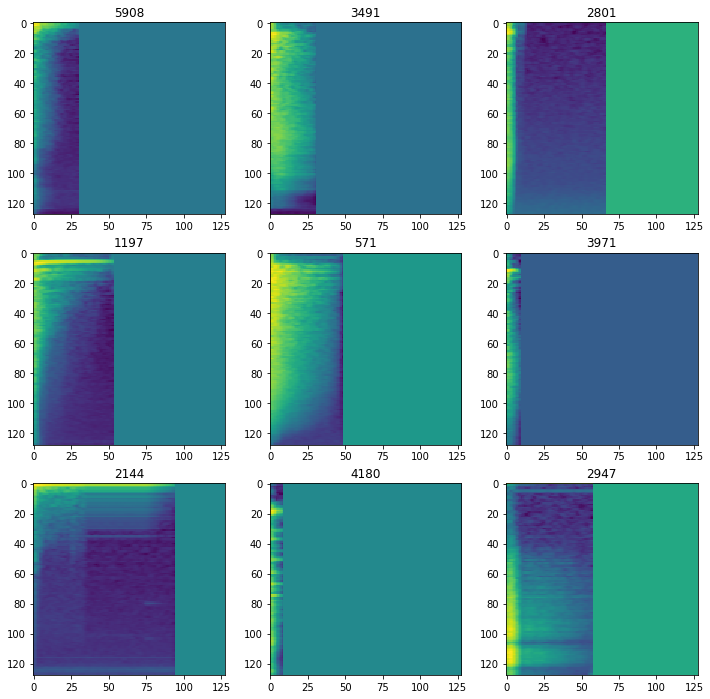

In [8]:
imshow_random_samples(drum_machines_dataset, 9, random_seed=44, cols=3)

In [9]:
model.load_state_dict(torch.load('../logs/conv_ae_3/checkpoints/train.19.pth')['model_state_dict'])
model.eval()

ConvAE(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 16, kernel_size=(9, 9), stride=(2, 2), padding=(4, 4))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(16, 24, kernel_size=(9, 9), stride=(2, 2), padding=(4, 4))
    (7): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(24, 32, kernel_size=(9, 9), stride=(2, 2), padding=(4, 4))
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): UpsamplingBilinear2d(scale_factor=(2.0, 2.0), mode=bilinear)
    (1): Conv2d(32, 24, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (2): BatchNorm2d(24, ep

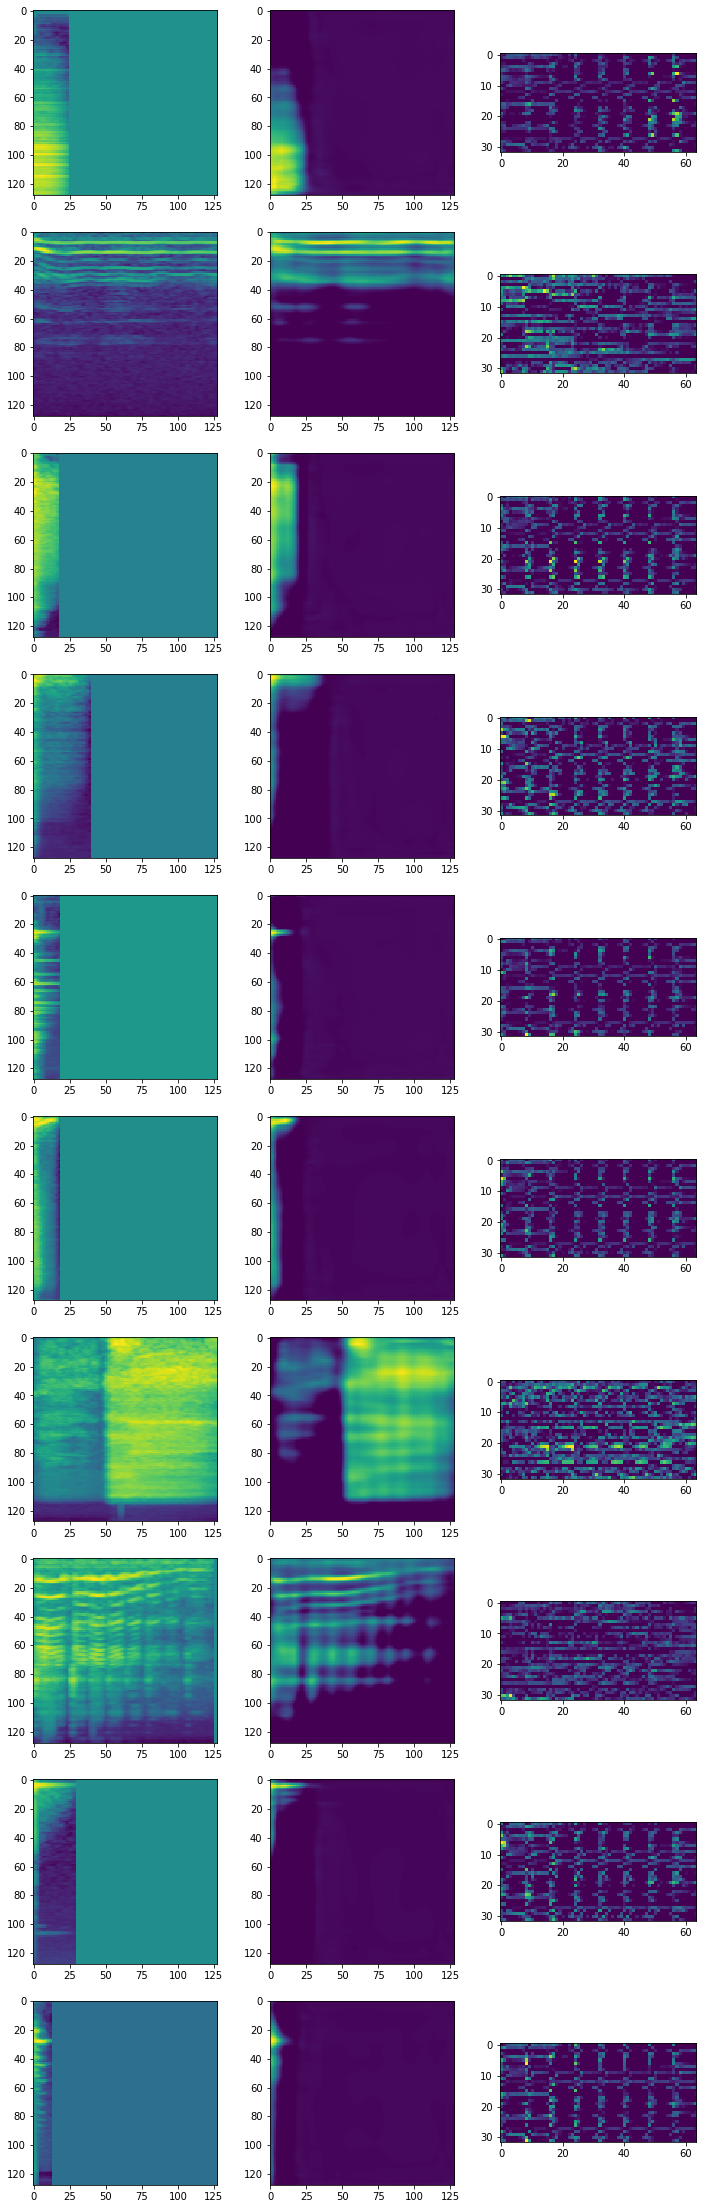

In [10]:
imshow_ae_output(model, common_set, 10)

In [11]:
runner = ConvAERunner()
runner.train(
    model=model, 
    optimizer=optimizer, 
    loaders=loaders,
    num_epochs=20,
    verbose=True,
    timeit=False,
    logdir="../logs/conv_ae_3"
)

1/20 * Epoch (train): 100% 202/202 [04:59<00:00,  1.48s/it, loss=291.962]
1/20 * Epoch (valid): 100% 23/23 [00:29<00:00,  1.30s/it, loss=291.936]
[2020-07-09 23:39:38,353] 
1/20 * Epoch 1 (train): loss=323.7894
1/20 * Epoch 1 (valid): loss=338.6199


INFO:metrics_logger:
1/20 * Epoch 1 (train): loss=323.7894
1/20 * Epoch 1 (valid): loss=338.6199


2/20 * Epoch (train): 100% 202/202 [04:59<00:00,  1.48s/it, loss=385.820]
2/20 * Epoch (valid): 100% 23/23 [00:29<00:00,  1.29s/it, loss=425.823]
[2020-07-09 23:45:08,104] 
2/20 * Epoch 2 (train): loss=318.7819
2/20 * Epoch 2 (valid): loss=334.7494


INFO:metrics_logger:
2/20 * Epoch 2 (train): loss=318.7819
2/20 * Epoch 2 (valid): loss=334.7494


3/20 * Epoch (train): 100% 202/202 [04:58<00:00,  1.48s/it, loss=440.671]
3/20 * Epoch (valid): 100% 23/23 [00:29<00:00,  1.30s/it, loss=364.669]
[2020-07-09 23:50:36,820] 
3/20 * Epoch 3 (train): loss=314.4370
3/20 * Epoch 3 (valid): loss=320.8083


INFO:metrics_logger:
3/20 * Epoch 3 (train): loss=314.4370
3/20 * Epoch 3 (valid): loss=320.8083


4/20 * Epoch (train): 100% 202/202 [04:57<00:00,  1.47s/it, loss=317.532]
4/20 * Epoch (valid): 100% 23/23 [00:30<00:00,  1.33s/it, loss=275.756]
[2020-07-09 23:56:05,587] 
4/20 * Epoch 4 (train): loss=309.8108
4/20 * Epoch 4 (valid): loss=334.7360


INFO:metrics_logger:
4/20 * Epoch 4 (train): loss=309.8108
4/20 * Epoch 4 (valid): loss=334.7360


5/20 * Epoch (train): 100% 202/202 [04:57<00:00,  1.47s/it, loss=257.452]
5/20 * Epoch (valid): 100% 23/23 [00:29<00:00,  1.26s/it, loss=257.673]
[2020-07-10 00:01:32,693] 
5/20 * Epoch 5 (train): loss=306.0401
5/20 * Epoch 5 (valid): loss=314.9488


INFO:metrics_logger:
5/20 * Epoch 5 (train): loss=306.0401
5/20 * Epoch 5 (valid): loss=314.9488


6/20 * Epoch (train): 100% 202/202 [04:58<00:00,  1.48s/it, loss=226.743]
6/20 * Epoch (valid): 100% 23/23 [00:29<00:00,  1.30s/it, loss=393.100]
[2020-07-10 00:07:01,423] 
6/20 * Epoch 6 (train): loss=302.0872
6/20 * Epoch 6 (valid): loss=317.9298


INFO:metrics_logger:
6/20 * Epoch 6 (train): loss=302.0872
6/20 * Epoch 6 (valid): loss=317.9298


7/20 * Epoch (train): 100% 202/202 [05:00<00:00,  1.49s/it, loss=240.910]
7/20 * Epoch (valid): 100% 23/23 [00:29<00:00,  1.27s/it, loss=369.577]
[2020-07-10 00:12:31,100] 
7/20 * Epoch 7 (train): loss=298.7750
7/20 * Epoch 7 (valid): loss=316.0222


INFO:metrics_logger:
7/20 * Epoch 7 (train): loss=298.7750
7/20 * Epoch 7 (valid): loss=316.0222


8/20 * Epoch (train): 100% 202/202 [04:58<00:00,  1.48s/it, loss=388.679]
8/20 * Epoch (valid): 100% 23/23 [00:29<00:00,  1.29s/it, loss=338.143]
[2020-07-10 00:17:59,117] 
8/20 * Epoch 8 (train): loss=296.0709
8/20 * Epoch 8 (valid): loss=307.3751


INFO:metrics_logger:
8/20 * Epoch 8 (train): loss=296.0709
8/20 * Epoch 8 (valid): loss=307.3751


9/20 * Epoch (train): 100% 202/202 [04:58<00:00,  1.48s/it, loss=304.410]
9/20 * Epoch (valid): 100% 23/23 [00:29<00:00,  1.27s/it, loss=180.833]
[2020-07-10 00:23:26,979] 
9/20 * Epoch 9 (train): loss=292.7364
9/20 * Epoch 9 (valid): loss=304.9475


INFO:metrics_logger:
9/20 * Epoch 9 (train): loss=292.7364
9/20 * Epoch 9 (valid): loss=304.9475


10/20 * Epoch (train): 100% 202/202 [04:59<00:00,  1.48s/it, loss=251.933]
10/20 * Epoch (valid): 100% 23/23 [00:29<00:00,  1.29s/it, loss=266.210]
[2020-07-10 00:28:56,616] 
10/20 * Epoch 10 (train): loss=289.6206
10/20 * Epoch 10 (valid): loss=300.3245


INFO:metrics_logger:
10/20 * Epoch 10 (train): loss=289.6206
10/20 * Epoch 10 (valid): loss=300.3245


11/20 * Epoch (train): 100% 202/202 [04:59<00:00,  1.48s/it, loss=225.019]
11/20 * Epoch (valid): 100% 23/23 [00:30<00:00,  1.32s/it, loss=473.853]
[2020-07-10 00:34:27,144] 
11/20 * Epoch 11 (train): loss=286.8196
11/20 * Epoch 11 (valid): loss=300.8470


INFO:metrics_logger:
11/20 * Epoch 11 (train): loss=286.8196
11/20 * Epoch 11 (valid): loss=300.8470


12/20 * Epoch (train): 100% 202/202 [04:58<00:00,  1.48s/it, loss=430.381]
12/20 * Epoch (valid): 100% 23/23 [00:28<00:00,  1.24s/it, loss=240.350]
[2020-07-10 00:39:55,138] 
12/20 * Epoch 12 (train): loss=285.0848
12/20 * Epoch 12 (valid): loss=293.3846


INFO:metrics_logger:
12/20 * Epoch 12 (train): loss=285.0848
12/20 * Epoch 12 (valid): loss=293.3846


13/20 * Epoch (train): 100% 202/202 [04:58<00:00,  1.48s/it, loss=243.428]
13/20 * Epoch (valid): 100% 23/23 [00:29<00:00,  1.28s/it, loss=188.098]
[2020-07-10 00:45:23,897] 
13/20 * Epoch 13 (train): loss=281.9042
13/20 * Epoch 13 (valid): loss=290.9155


INFO:metrics_logger:
13/20 * Epoch 13 (train): loss=281.9042
13/20 * Epoch 13 (valid): loss=290.9155


14/20 * Epoch (train): 100% 202/202 [04:59<00:00,  1.48s/it, loss=170.727]
14/20 * Epoch (valid): 100% 23/23 [00:31<00:00,  1.38s/it, loss=227.739]
[2020-07-10 00:50:56,460] 
14/20 * Epoch 14 (train): loss=279.2548
14/20 * Epoch 14 (valid): loss=291.2029


INFO:metrics_logger:
14/20 * Epoch 14 (train): loss=279.2548
14/20 * Epoch 14 (valid): loss=291.2029


15/20 * Epoch (train): 100% 202/202 [05:00<00:00,  1.49s/it, loss=207.635]
15/20 * Epoch (valid): 100% 23/23 [00:30<00:00,  1.32s/it, loss=223.812]
[2020-07-10 00:56:27,375] 
15/20 * Epoch 15 (train): loss=277.2254
15/20 * Epoch 15 (valid): loss=291.4408


INFO:metrics_logger:
15/20 * Epoch 15 (train): loss=277.2254
15/20 * Epoch 15 (valid): loss=291.4408


16/20 * Epoch (train): 100% 202/202 [04:59<00:00,  1.48s/it, loss=398.219]
16/20 * Epoch (valid): 100% 23/23 [00:28<00:00,  1.26s/it, loss=142.475]
[2020-07-10 01:01:55,970] 
16/20 * Epoch 16 (train): loss=275.8552
16/20 * Epoch 16 (valid): loss=281.4428


INFO:metrics_logger:
16/20 * Epoch 16 (train): loss=275.8552
16/20 * Epoch 16 (valid): loss=281.4428


17/20 * Epoch (train): 100% 202/202 [04:58<00:00,  1.48s/it, loss=219.789]
17/20 * Epoch (valid): 100% 23/23 [00:28<00:00,  1.25s/it, loss=388.938]
[2020-07-10 01:07:23,876] 
17/20 * Epoch 17 (train): loss=273.1607
17/20 * Epoch 17 (valid): loss=288.8892


INFO:metrics_logger:
17/20 * Epoch 17 (train): loss=273.1607
17/20 * Epoch 17 (valid): loss=288.8892


18/20 * Epoch (train): 100% 202/202 [04:58<00:00,  1.48s/it, loss=197.557]
18/20 * Epoch (valid): 100% 23/23 [00:29<00:00,  1.30s/it, loss=195.294]
[2020-07-10 01:12:52,224] 
18/20 * Epoch 18 (train): loss=271.1493
18/20 * Epoch 18 (valid): loss=283.1660


INFO:metrics_logger:
18/20 * Epoch 18 (train): loss=271.1493
18/20 * Epoch 18 (valid): loss=283.1660


19/20 * Epoch (train): 100% 202/202 [04:59<00:00,  1.48s/it, loss=192.055]
19/20 * Epoch (valid): 100% 23/23 [00:29<00:00,  1.30s/it, loss=234.254]
[2020-07-10 01:18:21,626] 
19/20 * Epoch 19 (train): loss=269.3700
19/20 * Epoch 19 (valid): loss=280.6103


INFO:metrics_logger:
19/20 * Epoch 19 (train): loss=269.3700
19/20 * Epoch 19 (valid): loss=280.6103


20/20 * Epoch (train): 100% 202/202 [05:00<00:00,  1.49s/it, loss=427.353]
20/20 * Epoch (valid): 100% 23/23 [00:29<00:00,  1.29s/it, loss=307.841]
[2020-07-10 01:23:52,259] 
20/20 * Epoch 20 (train): loss=268.5905
20/20 * Epoch 20 (valid): loss=285.4026


INFO:metrics_logger:
20/20 * Epoch 20 (train): loss=268.5905
20/20 * Epoch 20 (valid): loss=285.4026


Top best models:
../logs/conv_ae_3/checkpoints/train.19.pth	280.6103


In [9]:
vocal_splitter = DataSplit(vocal_sketch_dataset, shuffle=True, test_train_split=1)
vocal_loaders = {
    'train': vocal_splitter.get_train_loader(),
    'valid': vocal_splitter.get_validation_loader()
}

In [10]:
vocal_model = ConvAE()
vocal_optimizer = torch.optim.Adam(vocal_model.parameters())

In [11]:
vocal_runner = ConvAERunner()
vocal_runner.train(
    model=vocal_model, 
    optimizer=vocal_optimizer, 
    loaders=vocal_loaders,
    num_epochs=10,
    verbose=True,
    timeit=False,
    logdir="../logs/conv_ae_vocal_only"
)

1/10 * Epoch (train): 100% 80/80 [03:09<00:00,  2.37s/it, loss=8021.635]
1/10 * Epoch (valid): 100% 9/9 [00:22<00:00,  2.52s/it, loss=7526.929]
[2020-07-03 20:25:35,055] 
1/10 * Epoch 1 (train): loss=7401.8635
1/10 * Epoch 1 (valid): loss=7506.6778


INFO:metrics_logger:
1/10 * Epoch 1 (train): loss=7401.8635
1/10 * Epoch 1 (valid): loss=7506.6778


2/10 * Epoch (train): 100% 80/80 [03:07<00:00,  2.35s/it, loss=7221.808]
2/10 * Epoch (valid): 100% 9/9 [00:23<00:00,  2.56s/it, loss=6874.756]
[2020-07-03 20:29:06,469] 
2/10 * Epoch 2 (train): loss=7378.9483
2/10 * Epoch 2 (valid): loss=7479.3466


INFO:metrics_logger:
2/10 * Epoch 2 (train): loss=7378.9483
2/10 * Epoch 2 (valid): loss=7479.3466


3/10 * Epoch (train): 100% 80/80 [03:06<00:00,  2.33s/it, loss=7144.494]
3/10 * Epoch (valid): 100% 9/9 [00:22<00:00,  2.55s/it, loss=8035.771]
[2020-07-03 20:32:36,659] 
3/10 * Epoch 3 (train): loss=7361.2650
3/10 * Epoch 3 (valid): loss=7471.9321


INFO:metrics_logger:
3/10 * Epoch 3 (train): loss=7361.2650
3/10 * Epoch 3 (valid): loss=7471.9321


4/10 * Epoch (train): 100% 80/80 [03:08<00:00,  2.36s/it, loss=7218.886]
4/10 * Epoch (valid): 100% 9/9 [00:21<00:00,  2.40s/it, loss=6772.047]
[2020-07-03 20:36:07,938] 
4/10 * Epoch 4 (train): loss=7344.0023
4/10 * Epoch 4 (valid): loss=7415.3089


INFO:metrics_logger:
4/10 * Epoch 4 (train): loss=7344.0023
4/10 * Epoch 4 (valid): loss=7415.3089


5/10 * Epoch (train): 100% 80/80 [03:07<00:00,  2.35s/it, loss=7723.620]
5/10 * Epoch (valid): 100% 9/9 [00:22<00:00,  2.50s/it, loss=7236.979]
[2020-07-03 20:39:38,834] 
5/10 * Epoch 5 (train): loss=7328.1482
5/10 * Epoch 5 (valid): loss=7410.5750


INFO:metrics_logger:
5/10 * Epoch 5 (train): loss=7328.1482
5/10 * Epoch 5 (valid): loss=7410.5750


6/10 * Epoch (train): 100% 80/80 [03:07<00:00,  2.35s/it, loss=7006.094]
6/10 * Epoch (valid): 100% 9/9 [00:22<00:00,  2.52s/it, loss=7270.897]
[2020-07-03 20:43:10,200] 
6/10 * Epoch 6 (train): loss=7307.9733
6/10 * Epoch 6 (valid): loss=7405.2204


INFO:metrics_logger:
6/10 * Epoch 6 (train): loss=7307.9733
6/10 * Epoch 6 (valid): loss=7405.2204


7/10 * Epoch (train): 100% 80/80 [03:06<00:00,  2.33s/it, loss=6874.649]
7/10 * Epoch (valid): 100% 9/9 [00:22<00:00,  2.49s/it, loss=7055.676]
[2020-07-03 20:46:40,007] 
7/10 * Epoch 7 (train): loss=7289.7306
7/10 * Epoch 7 (valid): loss=7379.0826


INFO:metrics_logger:
7/10 * Epoch 7 (train): loss=7289.7306
7/10 * Epoch 7 (valid): loss=7379.0826


8/10 * Epoch (train): 100% 80/80 [03:05<00:00,  2.32s/it, loss=6926.575]
8/10 * Epoch (valid): 100% 9/9 [00:22<00:00,  2.51s/it, loss=7203.773]
[2020-07-03 20:50:09,243] 
8/10 * Epoch 8 (train): loss=7272.0808
8/10 * Epoch 8 (valid): loss=7382.2969


INFO:metrics_logger:
8/10 * Epoch 8 (train): loss=7272.0808
8/10 * Epoch 8 (valid): loss=7382.2969


9/10 * Epoch (train): 100% 80/80 [03:07<00:00,  2.34s/it, loss=7227.239]
9/10 * Epoch (valid): 100% 9/9 [00:22<00:00,  2.52s/it, loss=7247.564]
[2020-07-03 20:53:39,668] 
9/10 * Epoch 9 (train): loss=7255.1971
9/10 * Epoch 9 (valid): loss=7348.7209


INFO:metrics_logger:
9/10 * Epoch 9 (train): loss=7255.1971
9/10 * Epoch 9 (valid): loss=7348.7209


10/10 * Epoch (train): 100% 80/80 [03:06<00:00,  2.34s/it, loss=7308.058]
10/10 * Epoch (valid): 100% 9/9 [00:22<00:00,  2.55s/it, loss=7398.314]
[2020-07-03 20:57:10,332] 
10/10 * Epoch 10 (train): loss=7237.4228
10/10 * Epoch 10 (valid): loss=7324.6633


INFO:metrics_logger:
10/10 * Epoch 10 (train): loss=7237.4228
10/10 * Epoch 10 (valid): loss=7324.6633


Top best models:
../logs/conv_ae_vocal_only/checkpoints/train.10.pth	7324.6633


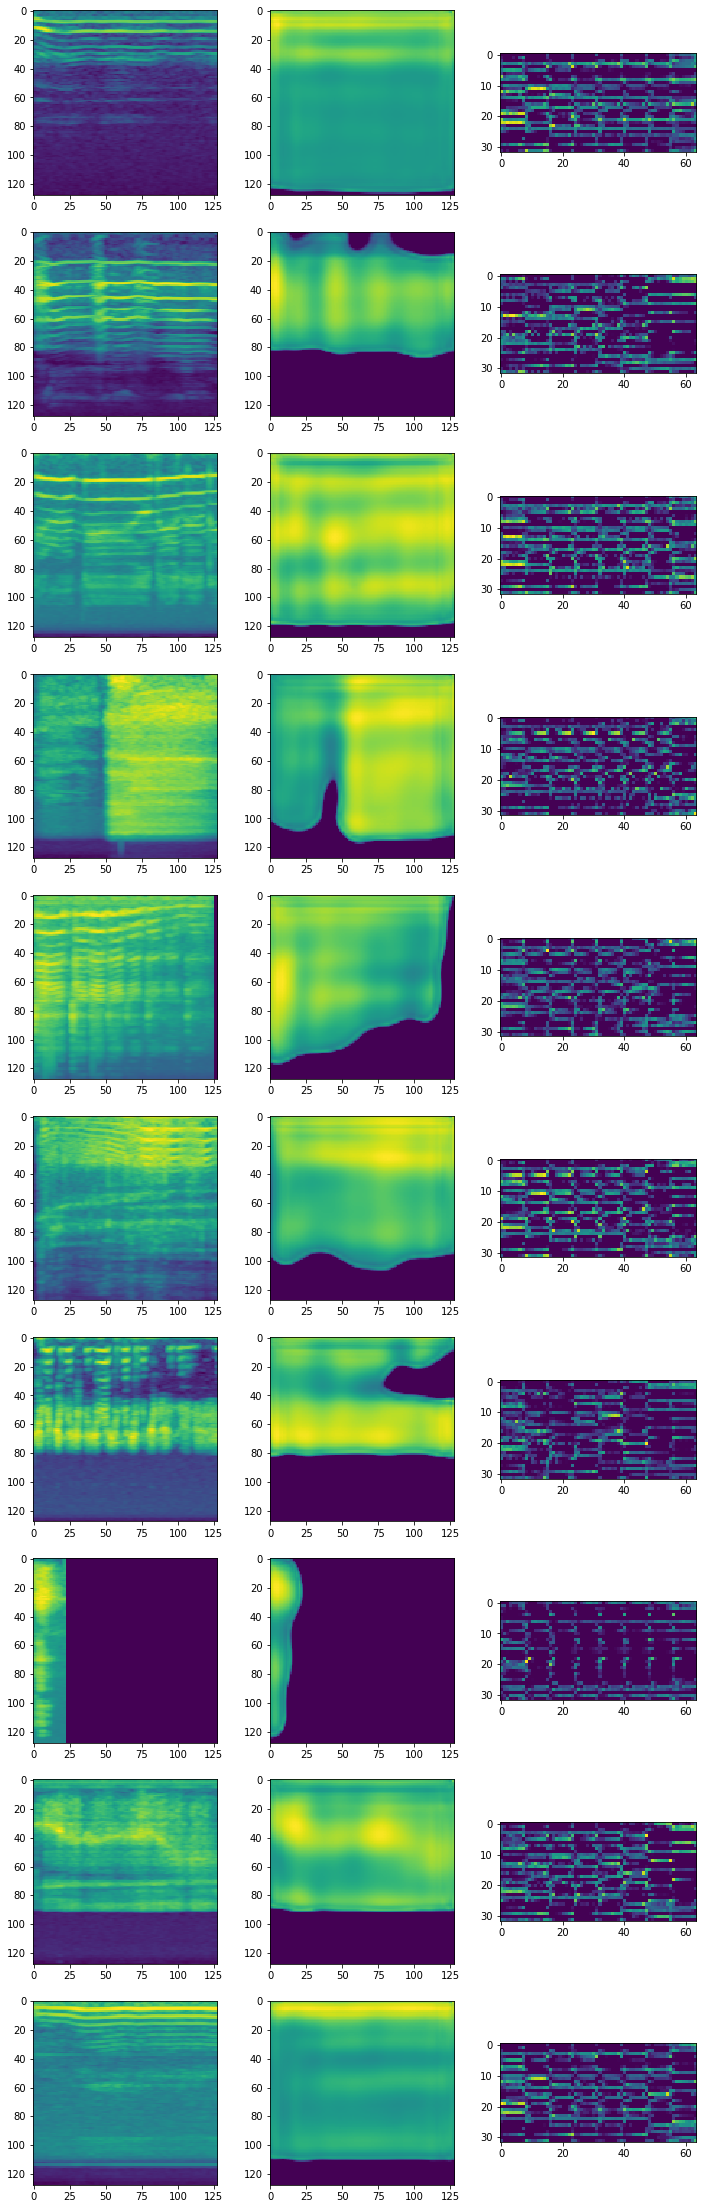

In [26]:
imshow_ae_output(vocal_model, vocal_sketch_dataset, 10)

In [16]:
vocal_sketch_dataset_unnorm = SampleSet(glob.glob('../data/vocal_imitations_sketch_included/included/*.wav'))
drum_machines_dataset_unnorm = SampleSet(glob.glob('../data/200DrumMachines/*/*.wav'))
common_set_unnorm = ConcatDataset([vocal_sketch_dataset_unnorm, drum_machines_dataset_unnorm])

In [17]:
model_unnorm = ConvAE()
model_unnorm.load_state_dict(torch.load('../logs/conv_ae_2/checkpoints/train.20.pth')['model_state_dict'])

<All keys matched successfully>

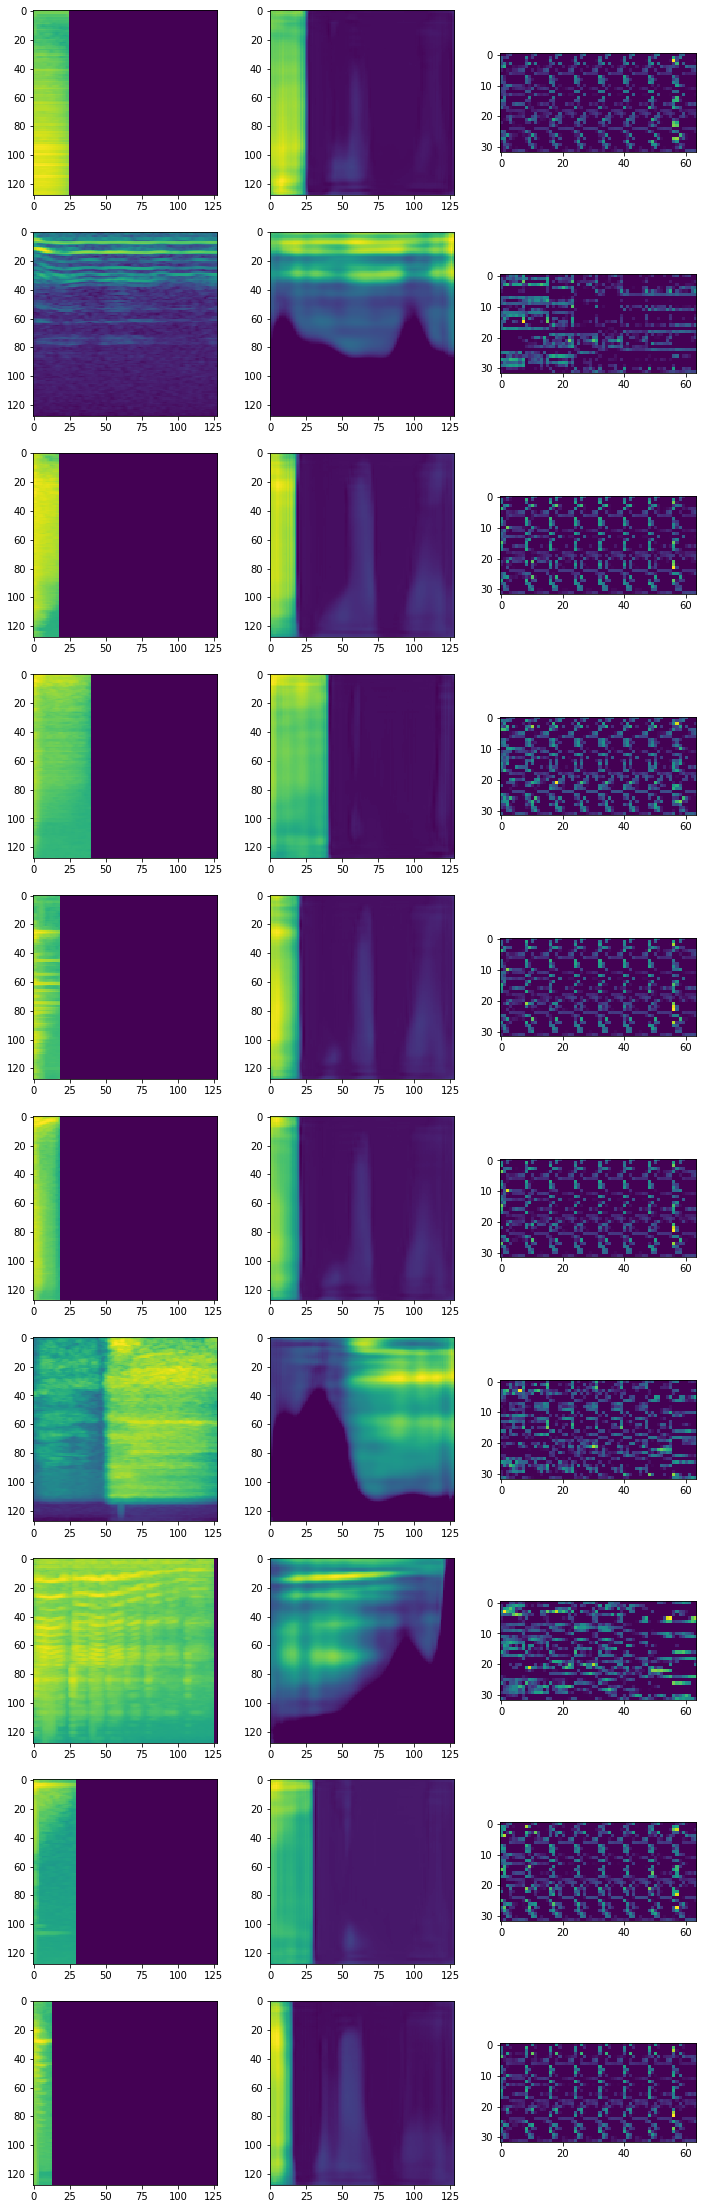

In [18]:
imshow_ae_output(model_unnorm, common_set_unnorm, 10)